# 1. Load the data and libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings 
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")

In [2]:
df_count=pd.read_csv('./dataset/final_sunspot_count_data.csv')
df_size=pd.read_csv('./dataset/final_sunspot_size_data.csv')

df_count['count'] = df_count['count'].replace(-1.0, 0)
df_size['Total'] = df_size['Total'].replace(-1.0, 0)

df_count['date'] = pd.to_datetime(df_count["date"]).dt.to_period('Y').astype(str)
df_size['date'] = pd.to_datetime(df_size['date']).dt.to_period('Y').astype(str)

df_count_sum = df_count.groupby('date', as_index=False)['count'].mean()
df_size_sum = df_size.groupby('date', as_index=False)['Total'].mean()

In [3]:
merged_df = pd.merge(df_count_sum, df_size_sum, on='date', how='inner')
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.to_period('Y').dt.to_timestamp()

In [4]:
df_count = merged_df[["date", "count"]]

In [5]:
df_copy = df_count.copy()

In [6]:
df_copy['Month']=df_copy.date.dt.month
df_copy['nth_year'] =[int(str(i)[3]) for i in (df_copy.date.dt.year)] # Note this is list comprehension 
df_copy['nth_year'].replace(0,10,inplace=True)

# Trend, Seasaonlity, and Residuals

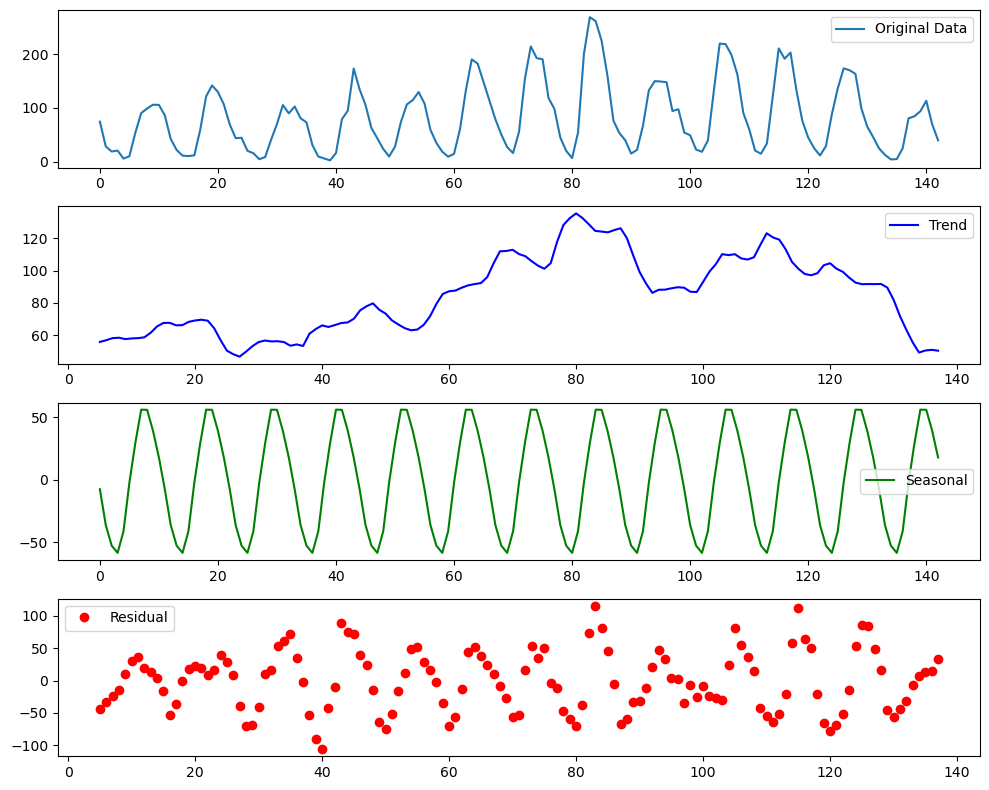

In [7]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# seasonal_decompose 함수를 사용하여 추세, 계절성 및 잔차를 계산합니다.
result = seasonal_decompose(df_copy['count'], model='additive', period=11)

# 추세, 계절성, 잔차를 그래프로 그립니다.
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Original Data')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend', color='blue')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual', color='red', marker='o', linestyle='None')
plt.legend()

plt.tight_layout()
plt.show()


# Normality (ADF, KPSS) 

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    print("#### Results of Dickey-Fuller Test ####")
    dftest = adfuller(df, autolag = "AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index = [
            "Test-Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations used",
        ]
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" %key] = value
        
    print(dfoutput)

In [9]:
from statsmodels.tsa.stattools import kpss

def kpss_test(df):
    print("#### Results of KPSS Test ####")
    statistic, p_value, n_lags, critical_values = kpss(df.values)
    
    print(f"KPSS Statistic: {statistic}")
    print(f"p-value: {p_value}")
    print(f"num lags: {n_lags}")
    print(f"Critical values: {critical_values}")
    for key, value in critical_values.items():
        print(f"{key}:{value}")

In [10]:
adf_test(df_copy['count'])
print("------------------------------------------------------------")
kpss_test(df_copy["count"])

#### Results of Dickey-Fuller Test ####
Test-Statistic                  -1.722885
p-value                          0.419362
#Lags Used                       8.000000
Number of Observations used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64
------------------------------------------------------------
#### Results of KPSS Test ####
KPSS Statistic: 0.3843234434215026
p-value: 0.08391230887004199
num lags: 5
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
10%:0.347
5%:0.463
2.5%:0.574
1%:0.739


In [11]:
count_diff = df_copy["count"].diff(11)[12:]
adf_test(count_diff)
print("------------------------------------------------------------")
kpss_test(count_diff)

#### Results of Dickey-Fuller Test ####
Test-Statistic                  -2.738863
p-value                          0.067551
#Lags Used                      11.000000
Number of Observations used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64
------------------------------------------------------------
#### Results of KPSS Test ####
KPSS Statistic: 0.2939900891472019
p-value: 0.1
num lags: 5
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
10%:0.347
5%:0.463
2.5%:0.574
1%:0.739


# ACF, PACF

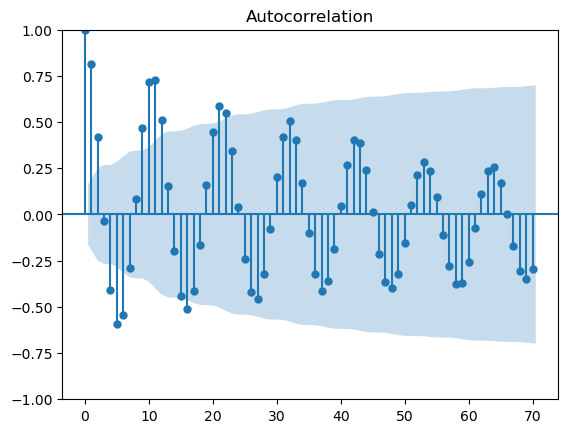

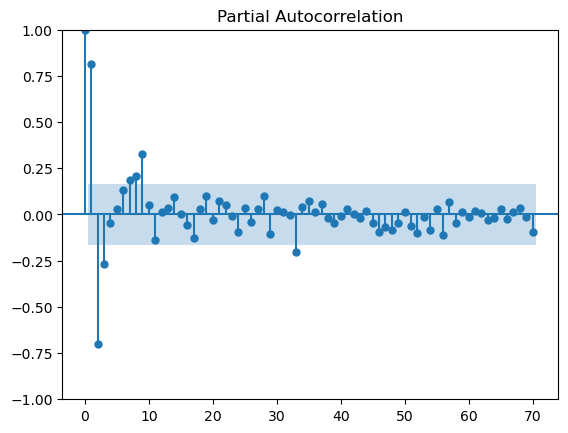

In [12]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#fig, axes = plt.subplots(2, 1, figsize=(20,15), dpi= 80)

#plot_acf(df_copy['count'], lags = 140)
#plot_pacf(df_copy['count'], lags = 140)
plot_acf(df_copy['count'], lags = 70)
plot_pacf(df_copy['count'], lags = 70)
plt.show()
#plot_pacf(df_copy['count'].tolist(), lags=20, ax=axes[1])

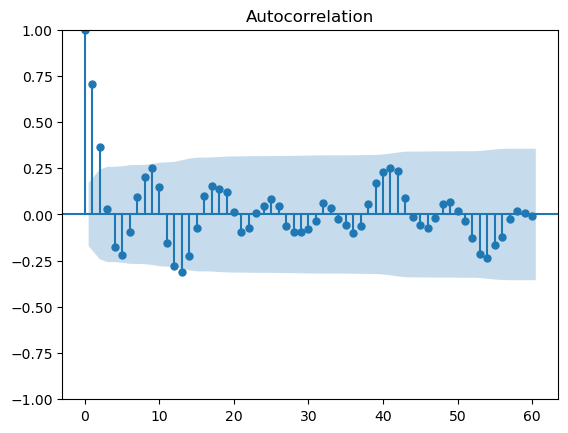

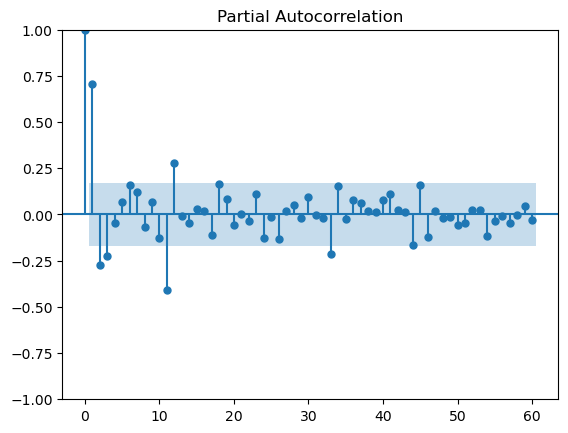

In [13]:
#plot_acf(count_diff, lags = 140)
#plot_pacf(count_diff, lags = 140)

plot_acf(count_diff, lags = 60)
plot_pacf(count_diff, lags = 60)
plt.show()

# Prediction on Time-series

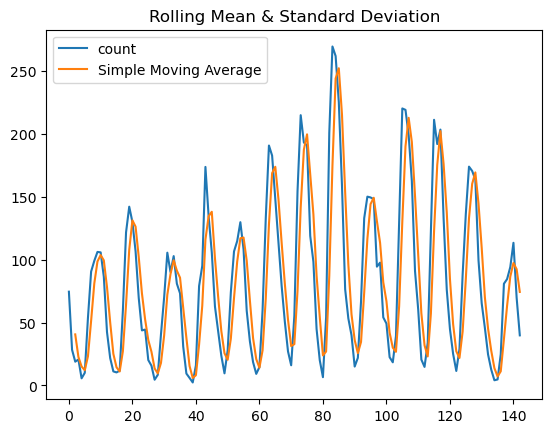

In [14]:
# Simple Moving Average
df_copy['count'][:200].plot()
df_copy['count'][:200].rolling(3).mean().plot(label='Simple Moving Average') 
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [15]:
def wma(weights): 
    def calc(x):
        return (weights*x).mean()
    return calc

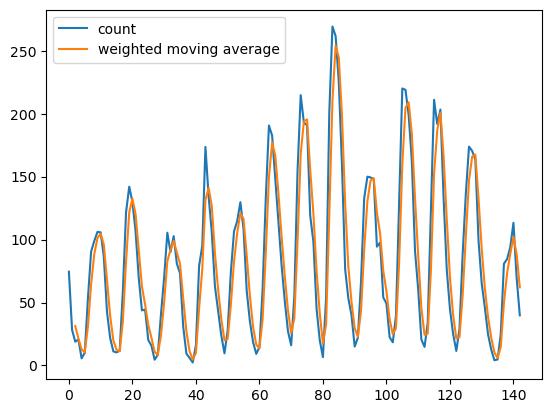

In [16]:
# weighted moving average
df_copy['count'][:200].plot()
df_copy['count'][:200].rolling(3).apply(wma(np.array([0.5,1,1.5]))).plot(label='weighted moving average')
plt.legend()
plt.show()

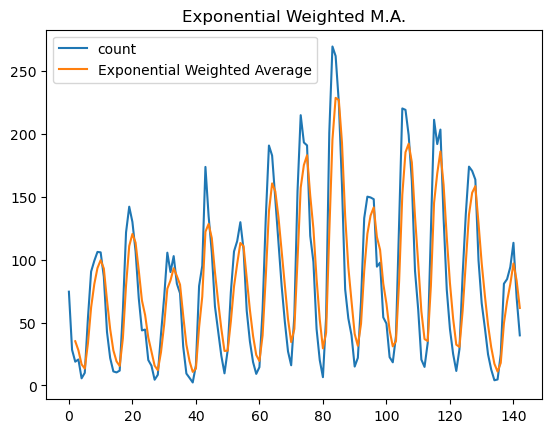

In [17]:
# Exponential Weighted Average
df_copy['count'][:200].plot()
df_copy['count'][:200].ewm(span=3, adjust=False, min_periods=3).mean().plot(label='Exponential Weighted Average')
plt.title('Exponential Weighted M.A.')
plt.legend()
plt.show()

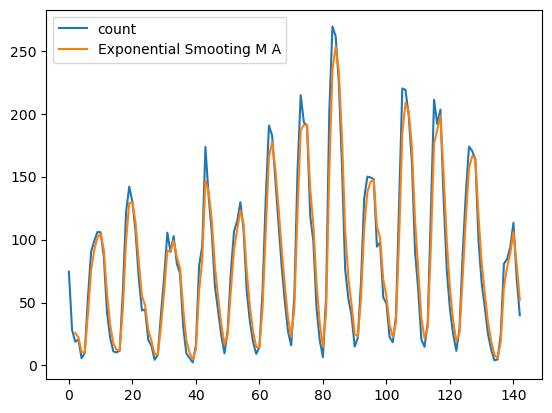

In [18]:
# Exponential Smooting M A
df_copy['count'][:200].plot()
df_copy['count'][:200].ewm(alpha=0.7, adjust=False, min_periods=3).mean().plot(label='Exponential Smooting M A')
plt.legend()
plt.show()

        date      count  Month  nth_year  Rolling mean      W_M_A      E_W_A  \
0 1874-01-01  74.520548      1         4           NaN        NaN  74.520548   
1 1875-01-01  28.339726      1         5           NaN        NaN  51.430137   
2 1876-01-01  18.923497      1         6     40.594590  31.328415  35.176817   
3 1877-01-01  20.660274      1         7     22.641166  21.361257  27.918546   
4 1878-01-01   5.701370      1         8     15.095047  12.891359  16.809958   

     E_S_M_A  
0        NaN  
1        NaN  
2  25.904640  
3  22.233584  
4  10.661034  


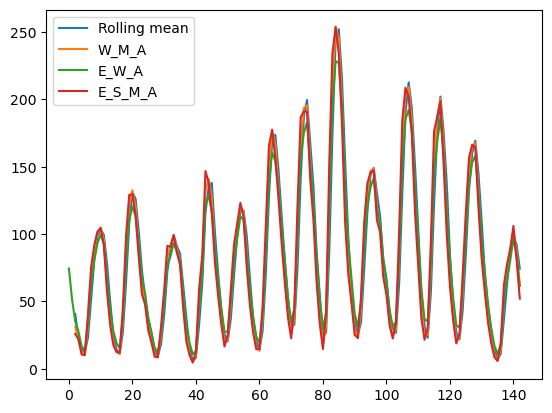

{'Rolling_Mean_RMSE': 415.1520089909868,
 'W_M_A_RMSE': 281.9942409499603,
 'E_W_A_RMSE': 323.8539499439074,
 'E_S_M_A_RMSE': 168.7436074845764}

In [19]:
df_with_diff_avg=df_copy.copy()
df_with_diff_avg['Rolling mean']=df_copy['count'].rolling(3).mean()
df_with_diff_avg['W_M_A']= df_copy['count'].rolling(window=3).apply(wma(np.array([0.5,1,1.5])))
df_with_diff_avg['E_W_A']= df_copy['count'].ewm(span=3, adjust=False, min_periods=0).mean()
df_with_diff_avg['E_S_M_A']= df_copy['count'].ewm(alpha=0.7, adjust=False, min_periods=3).mean()
print(df_with_diff_avg.head())

#df_with_diff_avg.set_index('Date', inplace=True)
df_with_diff_avg[["Rolling mean", "W_M_A", "E_W_A", "E_S_M_A"]].plot()
plt.show()

df_with_diff_avg.dropna(inplace=True)
df_with_diff_avg.head()

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def RMSE_CAL(df):
    Rolling_Mean_RMSE=np.sqrt(np.sum((df.iloc[:,0]-df.iloc[:,1])**2))
    W_M_A_RMSE=np.sqrt(np.sum((df.iloc[:,0]-df.iloc[:,2])**2))
    E_W_A_RMSE=np.sqrt(np.sum((df.iloc[:,0]-df.iloc[:,3])**2))
    E_S_M_A_RMSE=np.sqrt(np.sum((df.iloc[:,0]-df.iloc[:,4])**2))
    return {"Rolling_Mean_RMSE":Rolling_Mean_RMSE,"W_M_A_RMSE":W_M_A_RMSE,"E_W_A_RMSE":E_W_A_RMSE,"E_S_M_A_RMSE":E_S_M_A_RMSE}

RMSE_CAL(df_with_diff_avg[["count","Rolling mean", "W_M_A", "E_W_A", "E_S_M_A"]])

In [27]:
df_copy = df_copy.set_index('date')

In [30]:
df_copy[int(len(df_copy)*0.4):]

,count,Month,nth_year
date,,,
1931-01-01,35.065753,1,1
1932-01-01,18.560109,1,2
1933-01-01,9.227397,1,3
1934-01-01,14.556164,1,4
1935-01-01,60.175342,1,5
...,...,...,...
2012-01-01,84.538251,1,2
2013-01-01,94.021918,1,3
2014-01-01,113.345205,1,4


SARIMA (0, 0, 0)x(0, 0, 0, 11): 1023.5599001028883
SARIMA (0, 0, 0)x(0, 0, 1, 11): 956.908452596081
SARIMA (0, 0, 0)x(0, 0, 2, 11): 926.5004595985592
SARIMA (0, 0, 0)x(1, 0, 0, 11): 895.8223852250071
SARIMA (0, 0, 0)x(1, 0, 1, 11): 894.4542043382987
SARIMA (0, 0, 0)x(1, 0, 2, 11): 895.4650495709867
SARIMA (0, 0, 0)x(2, 0, 0, 11): 893.9829496164182
SARIMA (0, 0, 0)x(2, 0, 1, 11): 895.9768511358493
SARIMA (0, 0, 0)x(2, 0, 2, 11): 898.3031113633324
SARIMA (0, 0, 1)x(0, 0, 0, 11): 939.5539675902133
SARIMA (0, 0, 1)x(0, 0, 1, 11): 902.6190468330378
SARIMA (0, 0, 1)x(0, 0, 2, 11): 875.0515166274959
SARIMA (0, 0, 1)x(1, 0, 0, 11): 852.1524226088975
SARIMA (0, 0, 1)x(1, 0, 1, 11): 854.142125614984
SARIMA (0, 0, 1)x(1, 0, 2, 11): 858.5613766659834
SARIMA (0, 0, 1)x(2, 0, 0, 11): 854.1387214734242
SARIMA (0, 0, 1)x(2, 0, 1, 11): 854.3962759740374
SARIMA (0, 0, 1)x(2, 0, 2, 11): 857.74588758125
SARIMA (0, 0, 2)x(0, 0, 0, 11): 878.5182733947076
SARIMA (0, 0, 2)x(0, 0, 1, 11): 845.9529279339769
SAR

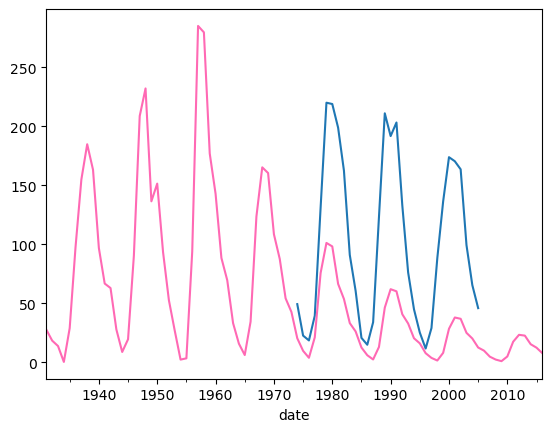

(<Figure size 1600x1000 with 4 Axes>,)

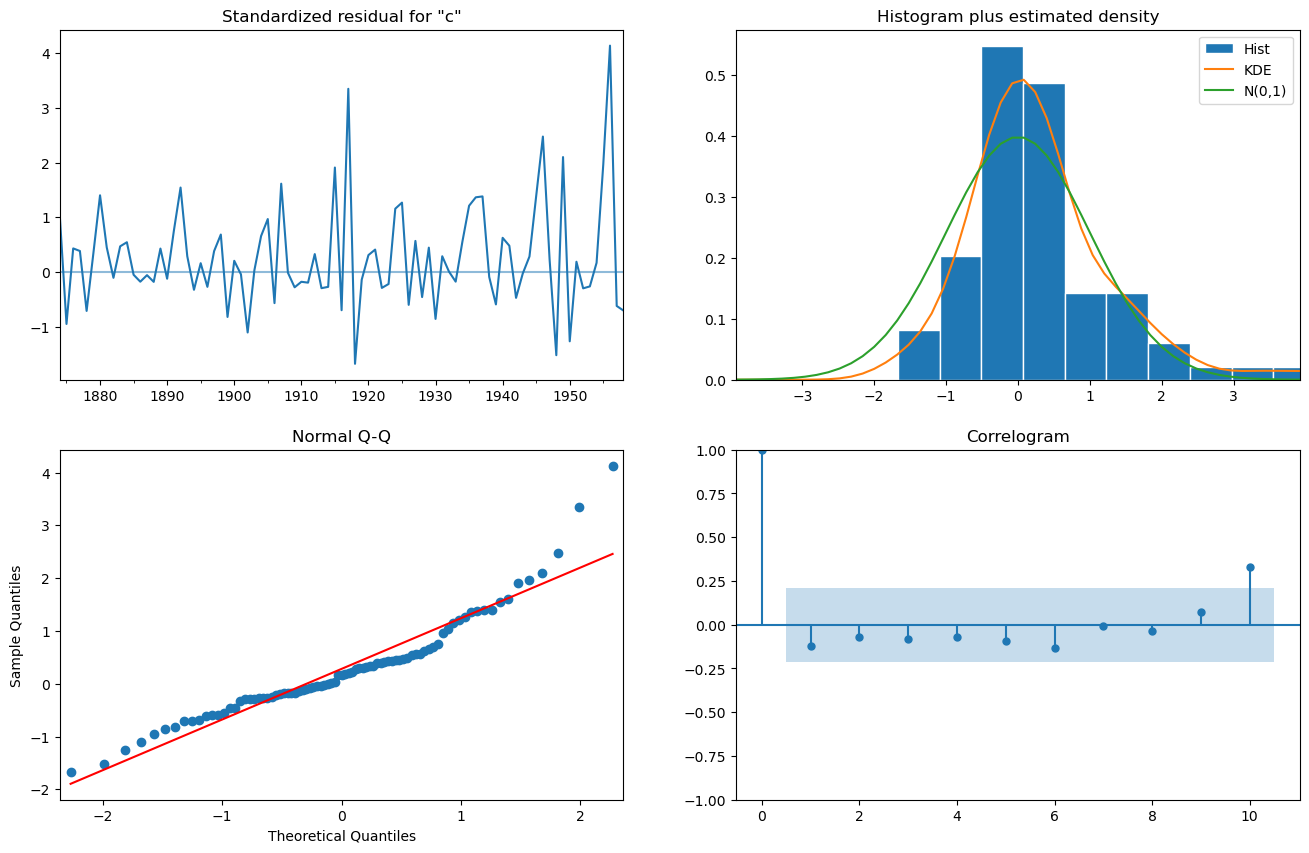

In [31]:
# SARIMA

def find_best_model(series, pdq_lst, s_pdq_lst, trans=False):

    train=series[:int(len(series)*0.6)]
    test=series[int(len(series)*0.4):]

    best_aic=np.inf
    best_pdq=None
    best_s_pdq=None
    best_model=None
    best_res=None

    for pdq in pdq_lst:
        for s_pdq in s_pdq_lst:
            try:
                tmp_model=SARIMAX(train, order=pdq, seasonal_order=s_pdq, exog=None)
                tmp_res=tmp_model.fit(disp=0)
                print('SARIMA {}x{}: {}'.format(pdq, s_pdq, tmp_res.aic))
                if tmp_res.aic<best_aic:
                    best_aic=tmp_res.aic
                    best_pdq=pdq
                    best_s_pdq=s_pdq
                    best_model=tmp_model
                    best_res=tmp_res
            except:
                print('error')

            

    print('\nbest_model SARIMA')
    print('nonseasonal {}, seasonal {}'.format(best_pdq, best_s_pdq))
    print(best_res.summary())

    pred=best_res.get_prediction(start=pd.to_datetime('1931-01-01'), end=pd.to_datetime('2016-01-01')).predicted_mean

    if trans=='sqrt':
        pred_val=np.power(pred, 2)
        test_val=np.power(test, 2)
        ax=np.power(series[100-11:], 2).plot()
    elif trans=='log':
        pred_val=np.exp(pred)-1
        test_val=np.exp(test)-1
        ax=(np.exp(series[100-11:])-1).plot()
    else:
        pred_val=pred
        test_val=test
        ax=series[int(len(series)*0.7):-11:].plot()
    pred_val.plot(ax=ax, color='hotpink')
    print(pred)
    rmse=np.sqrt(mean_squared_error(pred_val, test_val))
    
    print('\n******************')
    print('RMSE: %.2f'%(rmse))
    print('******************\n')
    
    return best_res, ax

p=q=range(0, 3)
d=range(0, 1)

P=Q=range(0, 3)
D=range(0, 1)
S=range(11, 12)

pdq_lst=list(itertools.product(p, d, q))
s_pdq_lst=list(itertools.product(P, D, Q, S))


res, ax=find_best_model(df_copy["count"], pdq_lst, s_pdq_lst)
plt.show()
res.plot_diagnostics(figsize=(16, 10)), 

In [ ]:
model = SARIMAX(df_copy["count"], order=(0, 0, 1), seasonal_order=(2, 0, 2, 11))
results = model.fit()

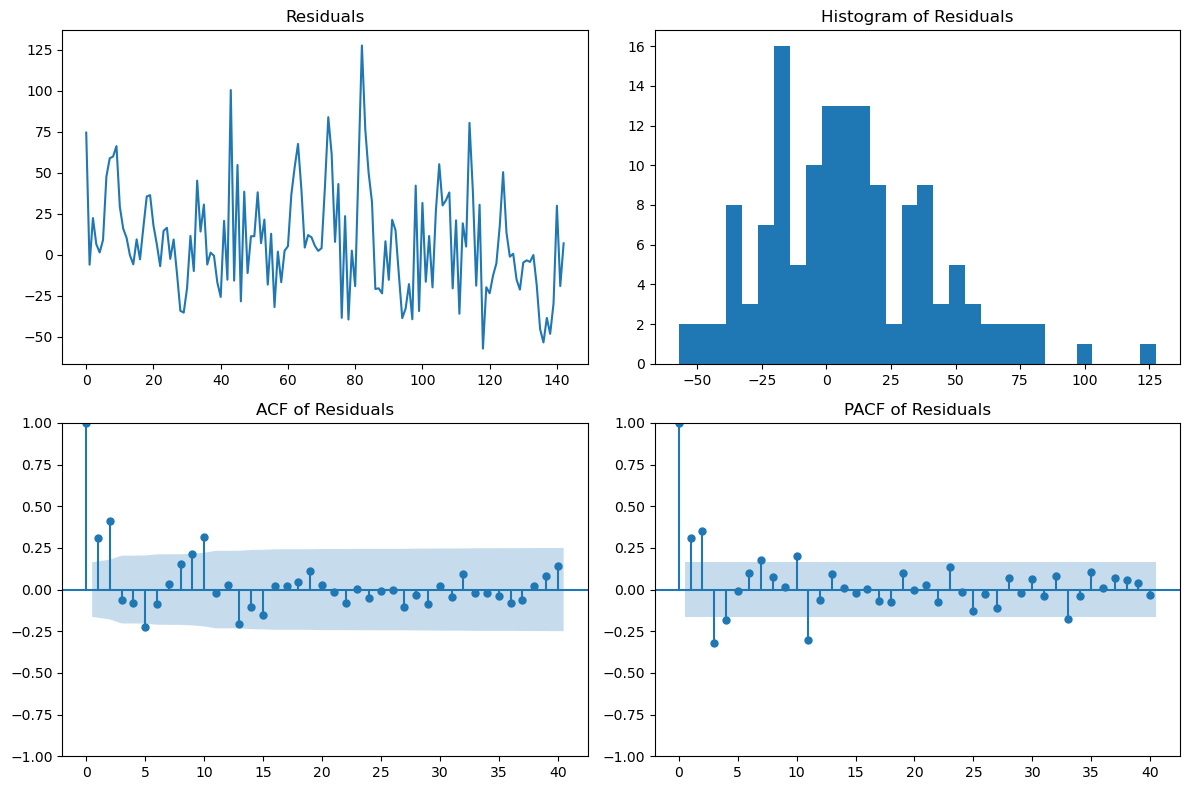

In [22]:
residuals = results.resid

# Plot residuals
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.plot(residuals)
plt.title('Residuals')

plt.subplot(222)
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')

plt.subplot(223)
plot_acf(residuals, ax=plt.gca(), lags=40)
plt.title('ACF of Residuals')

plt.subplot(224)
plot_pacf(residuals, ax=plt.gca(), lags=40)
plt.title('PACF of Residuals')

plt.tight_layout()
plt.show()